In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics

import scipy.linalg
import scipy.spatial.distance

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('ytick', labelsize=7)
import seaborn as sb

In [2]:
featdir = "/raid/data/bbbc021-DP/outputs/densenet_pretrainedw_800e_1e-2lr_64box_0.25factor/features/"
meta = pd.read_csv("/raid/data/bbbc021-DP/inputs/metadata/index.csv")

In [3]:
classes = meta["Compound_Concentration"].unique()
classes.sort()
classes = { classes[i]:i for i in range(len(classes))}
validation = meta[meta["replicate_use"] != "Training"]

In [4]:
def show_confusion_matrix(y_true, y_pred, classes):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm.T/np.sum(cm, axis=1), cmap=plt.cm.Blues)
    fig.colorbar(cax) 
    a = ax.set_yticks([x for x in classes.values()])
    b = ax.set_yticklabels([x for x in classes.keys()])

In [5]:
predictions = []
real_labels = []
wells = []
for i in tqdm(validation.index):
    filename = featdir + "{}_{}_{}.npz"
    filename = filename.format(
        validation.loc[i, "Metadata_Plate"], 
        validation.loc[i, "Metadata_Well"], 
        validation.loc[i, "Metadata_Site"]
    )
    with open(filename, "rb") as data:
        info = np.load(data)
        predictions.append(info["f"])
        label = validation.loc[i, "Compound_Concentration"]
        real_labels.append([classes[label]]*info["f"].shape[0])
        wells.append( validation.loc[i, "Metadata_Plate"] + "_" + validation.loc[i, "Metadata_Well"])

100%|██████████| 1268/1268 [00:01<00:00, 681.94it/s]


In [6]:
total_single_cells = 0
for i in range(len(predictions)):
    total_single_cells += predictions[i].shape[0]
    
print("Total images",len(predictions),predictions[0].shape)
print("Total single cells:", total_single_cells)

Total images 1268 (96, 104)
Total single cells: 160482


# Single cell classification accuracy

In [7]:
correct = 0
y_true = []
y_pred = []
for i in range(len(predictions)):
    for j in range(predictions[i].shape[0]):
        pred = np.argmax(predictions[i][j])
        if pred == real_labels[i][j]:
            correct += 1
        y_true.append(real_labels[i][j])
        y_pred.append(pred)

In [8]:
print("Correctly classified single cells:", 100*(correct / total_single_cells), "%")

Correctly classified single cells: 47.94681023416956 %


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


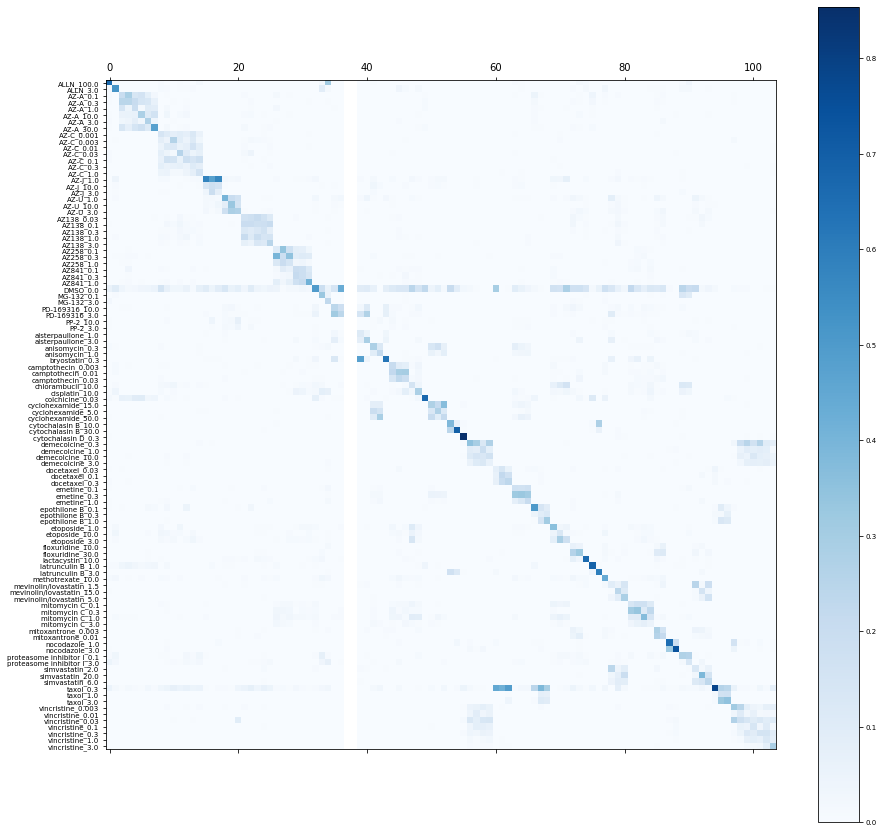

In [9]:
show_confusion_matrix(y_true, y_pred, classes)

# Image level classification accuracy

In [10]:
correct = 0
y_true = []
y_pred = []
for i in range(len(predictions)):
    aggregated = np.mean(predictions[i], axis=0)
    pred = np.argmax(aggregated)
    if pred == real_labels[i][0]:
        correct += 1
    y_true.append(real_labels[i][0])
    y_pred.append(pred)

In [11]:
print("Correctly classified images:", 100*(correct / len(predictions)), "%")

Correctly classified images: 77.9968454258675 %


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


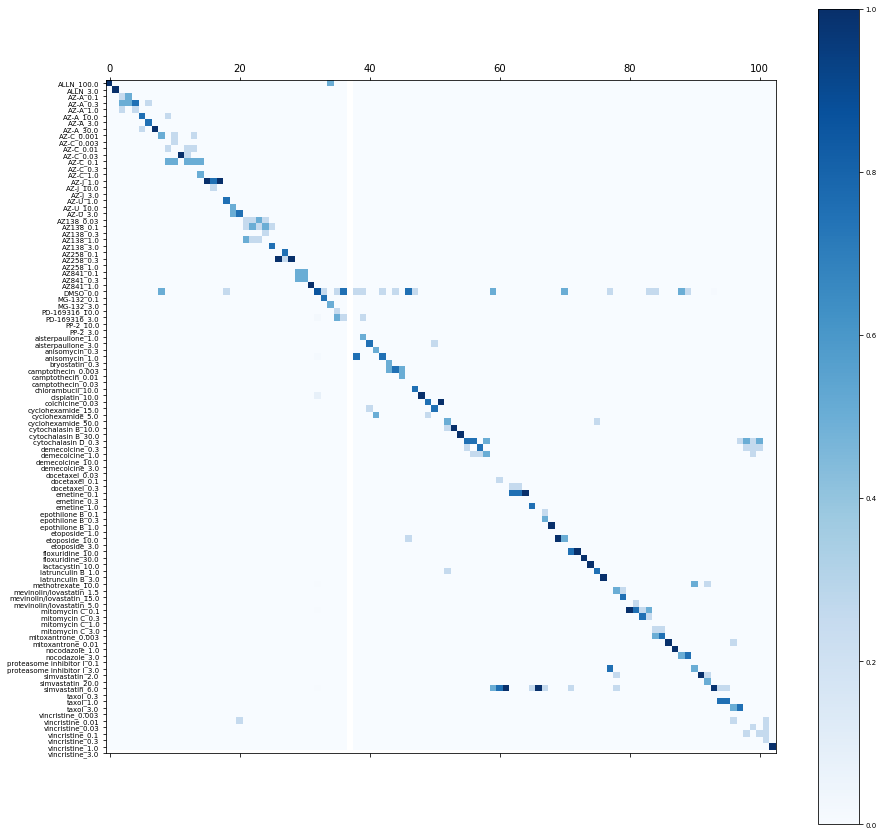

In [12]:
show_confusion_matrix(y_true, y_pred, classes)

# Well level classification accuracy

In [13]:
well_predictions = {}
well_labels = {}
for i in range(len(predictions)):
    try: well_predictions[wells[i]].append(predictions[i])
    except: well_predictions[wells[i]] = [predictions[i]]
    well_labels[wells[i]] = real_labels[i][0]

In [14]:
well_predictions = {k: np.mean(np.concatenate(well_predictions[k]), axis=0) for k in well_predictions.keys()}

In [15]:
correct = 0
y_true = []
y_pred = []
for k in well_predictions.keys():
    pred = np.argmax(well_predictions[k])
    if pred == well_labels[k]:
        correct += 1
    y_true.append(well_labels[k])
    y_pred.append(pred)

In [16]:
print("Correctly classified wells:", 100*(correct / len(well_predictions)), "%")

Correctly classified wells: 80.4416403785489 %


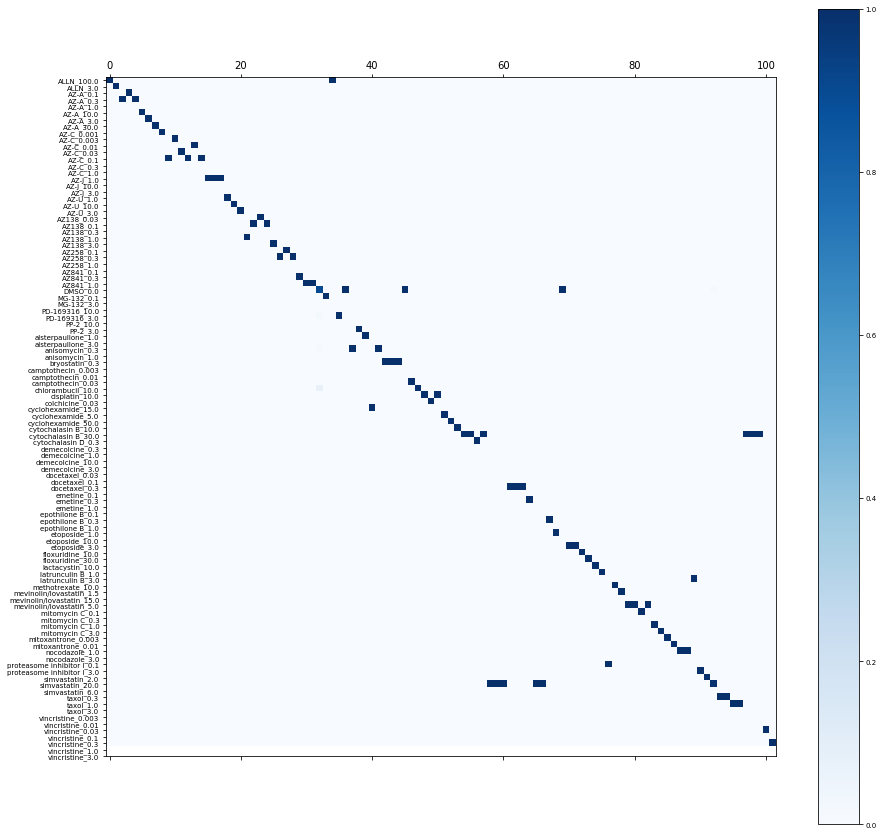

In [17]:
show_confusion_matrix(y_true, y_pred, classes)